# Présentation du notebook
-----------------------
`L'objectif` : Définir le délai de maintenance du modèle.


**La troisième partie de mon travail est de définir le seuil temporel à partir duquel la segmentation clientèle est toujours adaptée  :**<br>
Dans cet ultime partie, on va défeinir le seuil à partir duquel il est nécessaire d'effectuer à nouveau un entraînement d'un modèle de segmentation clientèle. Pour cela, on va simuler l'évolution de la stabilité des clusters sur différentes périodes. On va utiliser l'ARI pour mesurer la divergence des clusters et déterminer quand réentraîner le modèle. On va également regarder l’évolution de la distribution des features numériques dans le temps, en utilisant des méthodes graphiques.


# Configuration de l'environnement de travail

Tous les packages et modules utilisées au long de ce notebook ont été au préalablement installés dans l'environnement virtuel.<br>
**Pour identifier les catégories de modules**, reportez-vous aux commentaires dans la cellule de code :

In [18]:
# Import des packages standards & de manipulation de données
import joblib
import pandas as pd
from time import sleep

# Import des packages de visualisation
import matplotlib.animation as animation
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import Image, display

# Import des packages de machine learning
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline

# Chargement des données et du modèle de segmentation

Je récupère les données et le modèle de segmentation clientèle que j'ai sauvegardé dans les parties précédentes.

In [19]:
# Import the KMeans pipeline fit
pipeline = joblib.load("pipeline_kmeans.joblib")

# Import the cleaned data
customer_data_filtered = joblib.load("cleaned_data.joblib")

# Import the aligned data
customer_data_aligned = joblib.load("aligned_data.joblib")

# Préparation des données

Dans un premier temps, j'ai besoin de trier les données par date pour pouvoir simuler l'évolution de la stabilité des clusters dans le temps:

In [20]:
# Drop customer_id index and sort index by the last order date
data_aligned = customer_data_aligned.sort_index(level=1, ascending=True).droplevel(0)
data_filtered = customer_data_filtered.sort_index(level=1, ascending=True).droplevel(0)

Je récupère la date minimum et maximum de la base de données pour définir les bornes de la simulation:

In [21]:
# Find the minimum  and max date and convert it as a period object
min_date = data_filtered.index.min()
max_date = data_filtered.index.max()

# Compute timedelta between both dates
delta = max_date.to_period("D") - min_date.to_period("D")

# Print date objects
print(f"Date minimum: {min_date}\nDate maximum: {max_date}")
print("Time delta: ", delta)

Date minimum: 2016-10-05 00:32:31
Date maximum: 2018-08-27 23:31:47
Time delta:  <691 * Days>


Je vérifie en prévisualisant les données que la date est bien triée:

In [22]:
data_aligned.head(5)

,recence,avg_review_score,avg_diff_delivery_delay,avg_price,avg_freight
last_order_date,,,,,
2016-10-05 00:32:31,691,1,-25,24.900000,10.96
2016-10-05 07:31:49,691,1,-52,75.000000,20.58
2016-10-05 08:01:47,691,5,-43,43.889999,14.52
2016-10-05 08:04:21,691,1,-8,59.900005,11.31
2016-10-05 08:41:18,691,1,-29,119.989998,14.81


Je vais segmenter les données à partir de la fin des douze premiers mois pour simuler l'évolution de la stabilité des clusters sur les mois suivants<br>
Je vais sauvegarder sous une liste l'ensemble des paliers temporels:

In [23]:
# Create a list of index
date_index = []

# Appenb the minimum date
date_index.append(min_date)

# Compute and add the second date 360 days after the min
date_delta = (min_date.to_period("D") + 360).to_timestamp()

# Create and add a monthly date range index
date_range = pd.date_range(start=date_delta, end=max_date, freq="ME")
date_index.extend(date_range)

# Add the final date
date_index.append(max_date)

# Print the len and display the list
print("Nombre de dates: ", len(date_index))
date_index

Nombre de dates:  13


[Timestamp('2016-10-05 00:32:31'),
 Timestamp('2017-09-30 00:00:00'),
 Timestamp('2017-10-31 00:00:00'),
 Timestamp('2017-11-30 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-31 00:00:00'),
 Timestamp('2018-02-28 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2018-04-30 00:00:00'),
 Timestamp('2018-05-31 00:00:00'),
 Timestamp('2018-06-30 00:00:00'),
 Timestamp('2018-07-31 00:00:00'),
 Timestamp('2018-08-27 23:31:47')]

A l'aide de la liste des dates segmentées, je vais déjà simuler les labels et centroides prédits sur les douze premiers moise en utilisant les paramètres du précédent modèle de segmentation:

In [24]:
# Create a dict for labels predictions from a model fit only on the first year
predict_labels = dict()
predict_centroids = dict()

# Create a list of dataframe to compare distributions through time
distributions = []
i = 0
start_index = date_index[i].strftime("%Y-%m-%d")

# Create a new pipeline with the same steps as the previous fitted model
new_pipeline = Pipeline(steps=pipeline.get_params()["steps"])
while i < len(date_index) - 1:
    key = f"X{str(i+12)}"
    i += 1
    end_index = date_index[i].strftime("%Y-%m-%d")
    # Assign the subset & add it to the distributions list with the key
    X = data_filtered.loc[start_index:end_index, :]
    distributions.append((key, X))
    if i == 1:
        new_pipeline.fit(X)
        predict_centroids[key] = new_pipeline[-1].cluster_centers_
    predict_labels[key] = new_pipeline.predict(X)

A présent, je vais réaliser la simulation de l'évolution de la stabilité des clusters sur les mois suivants avec les labels et les centroides:

In [25]:
# Create a dict for labels predictions for models fit on each period of data
fit_predict_labels = dict()
fit_predict_centroids = dict()

# Iterate trhough each period
for i, (key, distribution) in enumerate(distributions):
    # Define the pipeline steps
    new_pipeline = Pipeline(steps=pipeline.get_params()["steps"])
    fit_predict_labels[key] = new_pipeline.fit_predict(distribution)
    fit_predict_centroids[key] = new_pipeline[-1].cluster_centers_

Je vais pouvoir calculer l'ARI pour chaque période de simulation par rapport aux douze premiers mois:

In [26]:
# Create a list containing tuples with features for each period
results = []
for (keys, labels_true), labels_pred in zip(
    predict_labels.items(), fit_predict_labels.values()
):
    results.append(
        (
            keys,
            int(keys.strip("X")),
            len(labels_true),
            adjusted_rand_score(labels_true, labels_pred),
        )
    )
# Create a dataframe with the results data
df_results = pd.DataFrame(
    data=results,
    columns=["name", "duration_in_months", "sample_size", "adjusted_rand_score"],
    index=date_index[1:],
)
# Display the results
df_results


,name,duration_in_months,sample_size,adjusted_rand_score
2017-09-30 00:00:00,X12,12,24822,1.000000
2017-10-31 00:00:00,X13,13,29092,0.847280
2017-11-30 00:00:00,X14,14,36075,0.685251
2017-12-31 00:00:00,X15,15,41387,0.634168
2018-01-31 00:00:00,X16,16,48173,0.572841
2018-02-28 00:00:00,X17,17,54415,0.548120
2018-03-31 00:00:00,X18,18,61188,0.508017
2018-04-30 00:00:00,X19,19,67791,0.430495
2018-05-31 00:00:00,X20,20,74388,0.381661
2018-06-30 00:00:00,X21,21,80379,0.279467


Je constate qu'à +6 mois le seuil des 0.5 est atteint.<br>
Je vais donc définir le seuil de maintenance du modèle à 6 mois.<br>
Je vais également regarder l'évolution de la distribution des features numériques dans le temps pour vérifier si le modèle est toujours adapté.

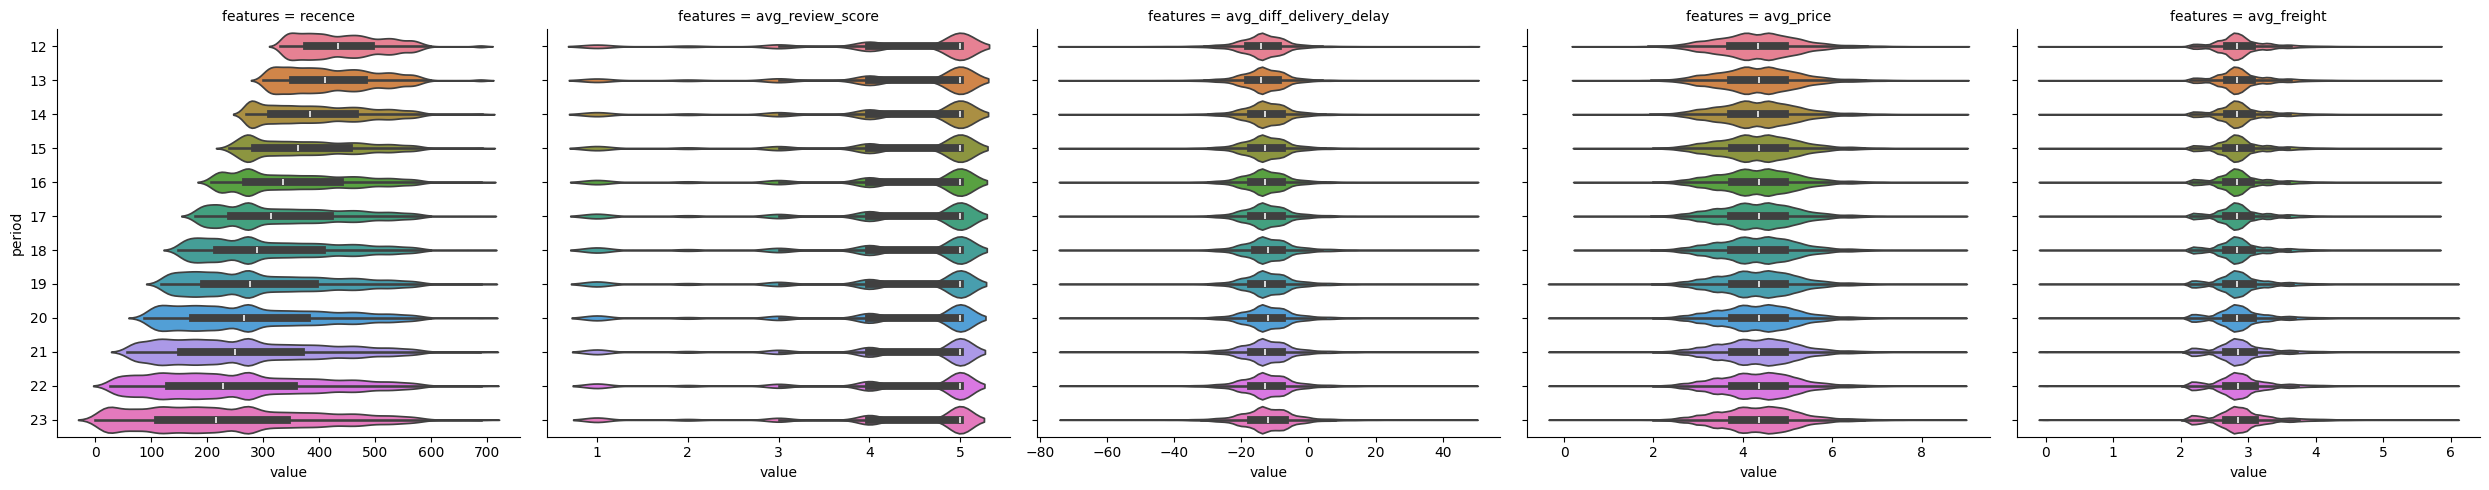

In [27]:
# Create a new dataframe with a new period 'month' column and plot violin plots for each feature
pd.melt(
    frame=pd.concat(
        [
            pd.DataFrame(distribution).assign(**{"period": key.strip("X")})
            for key, distribution in distributions
        ]
    ),
    id_vars=["period"],
    value_vars=[
        "recence",
        "avg_review_score",
        "avg_diff_delivery_delay",
        "avg_price",
        "avg_freight",
    ],
    var_name="features",
    value_name="value",
).pipe(
    sns.catplot,
    kind="violin",
    x="value",
    y="period",
    hue="period",
    col="features",
    sharex=False,
)
plt.show()


On peut voir l'évolution de la distribution des features numériques dans le temps et très logiquement sur la récence, variable temporelle.<br>
On peut voir une augement des délais, prix et frais de port dans le temps et peut être une baisse des mécontents également.


Regardons à présent l'évolution de l'ARI dans le temps:

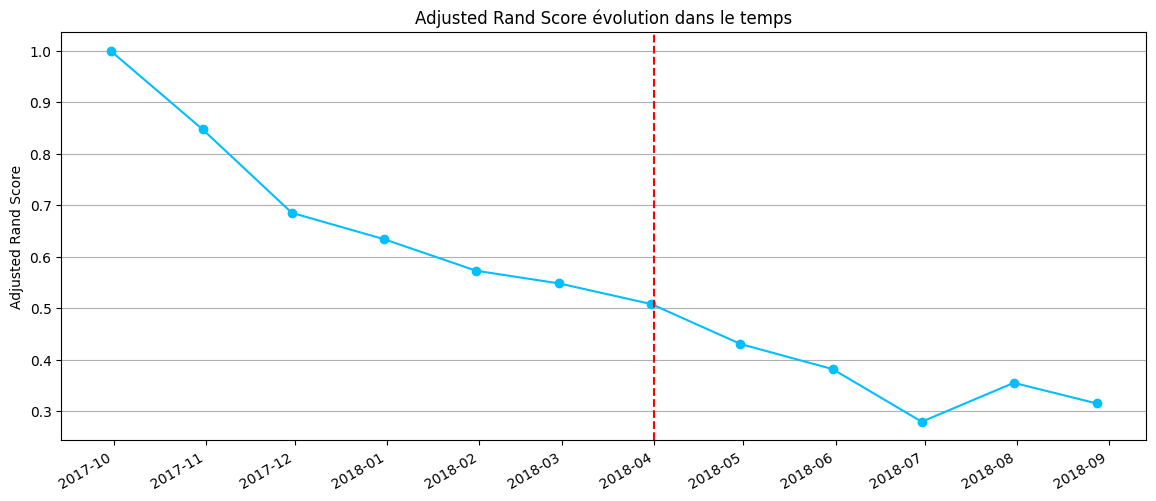

In [28]:
# Create the ax
_, ax = plt.subplots(figsize=(14, 6))

# Plot the ARI curve through time
(
    df_results["adjusted_rand_score"]
    .plot(
        title="Adjusted Rand Score évolution dans le temps",
        color="deepskyblue",
        marker="o",
    )
    .set(ylabel="Adjusted Rand Score")
)
# Add a vertical line at 2018-04-01
plt.axvline(x="2018-04-01", color="red", linestyle="--")
ax.grid(axis="y", visible=True)
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.show()


Pour analyser quelles sont les variables qui ont le plus d'impact sur la stabilité des clusters, je vais regarder les features les plus importantes pour chaque période de simulation :

In [29]:
# Define the number of iterations
iterations = len(results)
print("Nombre d'itérations: ", iterations)

# Rename the columns of the customer data
customer_data_filtered.columns = [
    "recence",
    "note moyenne",
    "diff. moyenne délai livraison",
    "prix moyen",
    "frais de port moyen",
]
# Create a list of DataFrame with the same iteration of baseline clusters centroids
df_predicted = [
    pd.DataFrame(
        data=predict_centroids["X12"], columns=customer_data_filtered.columns
    ).assign(**{"Group": "segments_reference_12M"})
    for _ in range(iterations)
]

# Create a list of DataFrame with each period of the fit_predicted clusters centroids
df_fit_predicted = [
    pd.DataFrame(
        data=fit_predict_centroids[f"X{str(i+12)}"],
        columns=customer_data_filtered.columns,
    ).assign(**{"Group": f"segments_predits_{str(i+12)}M"})
    for i in range(iterations)
]

# The lists must have the same size
assert len(df_predicted) == len(
    df_fit_predicted
), "Attention, les listes ne sont pas de même longueur"


Nombre d'itérations:  12


In [30]:
%%capture
# Create a list of dataframe with each predicted centroids vs baseline centroids for each period
all_centroids = [pd.concat([c1, c2]) for c1, c2 in zip(df_predicted, df_fit_predicted)]

# Create the fig & ax
fig, ax = plt.subplots(figsize=(10, 6))


# Define the update function for FuncAnimation
def update(iterations, all_centroids, ax):
    ax.clear()
    parallel_coordinates(
        all_centroids[iterations],
        class_column="Group",
        color=["deepskyblue", "crimson"],
    )
    ax.set_title(
        f"Evolution des centroides: {date_index[iterations+1].to_period('D')} (+{iterations} mois)"
    )
    ax.set_ylim(-2.25, 2.5)


# Create the animation
ani = animation.FuncAnimation(
    fig,
    update,  # function generating each plot
    frames=iterations,  # update first arg is frames
    fargs=(all_centroids, ax),  # update others args are defined here
    interval=100,  # bypass by the fps arg in ani.save
    repeat=True,
)

# Save it in a gif, showed in a markdown cell below
ani.save("animation_drawing.gif", writer="ffmpeg", fps=1)
sleep(5)

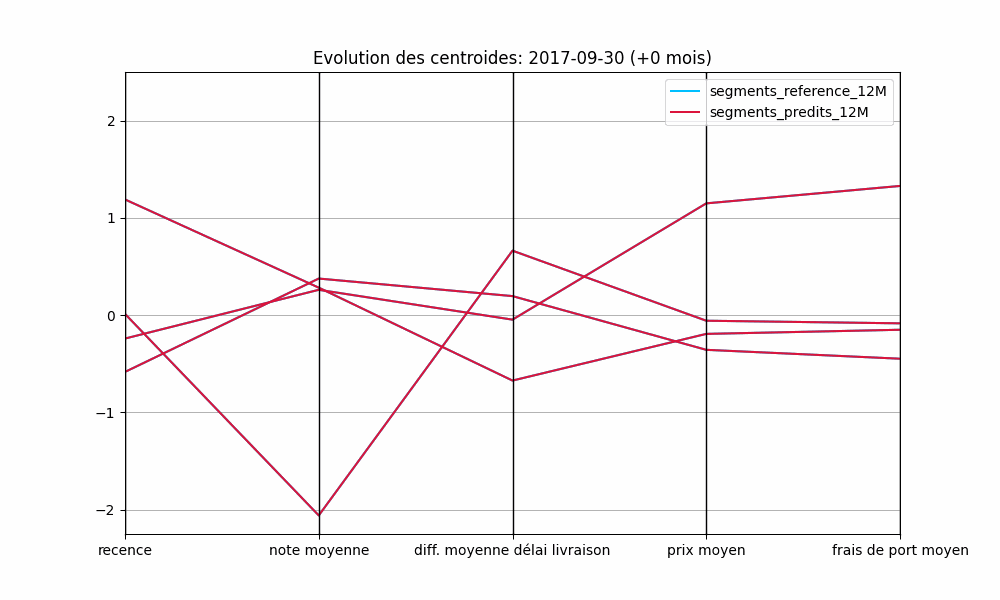

In [31]:
# Display the gif
display(Image('animation_drawing.gif'))

On peut constater sur le GIF que le centroide de la variable qui diffère le plus dans le temps est celle de la différence moyenne entre le délai réel et le délai estimé.<br>
On a pu constaté que celui-ci pouvait varier dans le temps et également sa pertinence sur la note de satisfaction client et aussi leur possible fidélité dans le temps.<br>
Cette variable a donc beaucoup d'importance sur les segments des clients et elle induit de la saisonnalité.


On peut aussi également voir de la variance sur le cluster des prix dans le temps et encore une fois cette variable suit en général une tendance haussière dans le temps à cause de l'inflation.<br>
Il est donc important de tenir compte de la saisonnalité et de l'inflation dans le temps et de reproduire une segmentation avec les nouveaux comportents clients mais aussi l'inflation.